In [155]:
# ! pip install pandas
# ! pip install numpy
# ! pip install matplotlib
# ! pip install pmdarima
# ! pip install arch

In [156]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
import yfinance as yf  # Import yfinance library for fetching historical stock data
import math
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from arch import arch_model
from arch.univariate import HARX
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore')


# Task 1

### Task 1.1

In [157]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('content/IBM_202001.csv.gz', compression='gzip')

original_length = len(df)
data = df.copy()
original_length


# F1
# Removing entries with either transaction price, transaction size, ask price, ask size, bid price or bid size ≤ 0
df_out = (df['NBB'] <= 0) | (df['NBBqty'] <= 0) |  (df['NBO'] <= 0) | (df['NBOqty'] <= 0) | (df['PRICE'] <= 0) | (df['SIZE'] <= 0)
df = df[~df_out].reset_index(drop=True)

# calculating no. of entries removed in f1
f1 = original_length - len(df)
f1_cleaned_length = len(df)


# F2
# Removing entries with either transaction price, transaction size, ask price, ask size, bid price or bid size ≤ 0
df_out = (df['NBB'] <= 0) | (df['NBBqty'] <= 0) |  (df['NBO'] <= 0) | (df['NBOqty'] <= 0) | (df['PRICE'] <= 0) | (df['SIZE'] <= 0)
df = df[~df_out].reset_index(drop=True)

# calculating no. of entries removed in f1
f1 = original_length - len(df)
f1_cleaned_length = len(df)


# F2
# Remove entries with negative bid-ask spread
df['SPREAD'] = df['NBO'] - df['NBB']
df = df[~(df['SPREAD'] <= 0)].reset_index(drop=True)

f2 = f1_cleaned_length - len(df)
f2_cleaned_length = len(df)


# F3
df['Stamp'] = pd.to_datetime(df['DATE'], format='%d%b%Y') + df['TIME_M'].apply(lambda x: pd.Timedelta(x,unit='sec'))
# Group by 'DATE', 'TIME', 'EX', and 'BuySell'
df = df.groupby(['Stamp', 'DATE', 'EX', 'BuySell']).agg({
    'PRICE': 'median',
    'NBO': 'median',
    'NBB': 'median',
    'SIZE': 'sum',
    'NBOqty': 'sum',
    'NBBqty': 'sum'
}).reset_index()

f3 = f2_cleaned_length - len(df)
f3_cleaned_length = len(df)


# F4
# Remove entries for which the spread is more that 50 times the median spread on that day
df['SPREAD'] = df['NBO'] - df['NBB']

medspread = df['SPREAD'].median()
df = df[~(df['SPREAD'] > 50*medspread)].reset_index(drop=True)

f4 = f3_cleaned_length - len(df)
f4_cleaned_length = len(df)


# F5
## Delete entries with prices that are above the `ask' plus the bid–ask spread. 
## Similar for entries with prices below the `bid' minus the bid–ask spread
df_out = (df['PRICE'] > df['NBO'] + df['SPREAD']) | (df['PRICE'] < df['NBB'] - df['SPREAD'])
df = df[~df_out]

f5 = f4_cleaned_length - len(df)
f5_cleaned_length = len(df)


# Summary
summary = pd.DataFrame({
    'F1': [f1, f1/original_length*100],
    'F2': [f2, f2/original_length*100],
    'F3': [f3, f3/original_length*100],
    'F4': [f4, f4/original_length*100],
    'F5': [f5, f5/original_length*100],
}, index=['Number', 'Proportion'])
summary.round(2)

,F1,F2,F3,F4,F5
Number,0.0,14375.00,222406.00,0.0,7063.00
Proportion,0.0,1.46,22.58,0.0,0.72


### Task 1.2

In [158]:
df

,Stamp,DATE,EX,BuySell,PRICE,NBO,NBB,SIZE,NBOqty,NBBqty,SPREAD
0,2020-01-02 09:30:00.226,02JAN2020,P,1.0,135.100,135.10,134.88,2.0,1000.0,200.0,0.22
1,2020-01-02 09:30:00.381,02JAN2020,K,1.0,135.090,135.10,134.62,1.0,500.0,600.0,0.48
2,2020-01-02 09:30:00.600,02JAN2020,N,1.0,135.000,135.10,134.62,148164.0,1000.0,1200.0,0.48
3,2020-01-02 09:30:00.609,02JAN2020,N,1.0,134.990,135.10,134.62,11.0,500.0,600.0,0.48
4,2020-01-02 09:30:00.642,02JAN2020,D,1.0,134.995,135.00,134.91,40.0,500.0,100.0,0.09
...,...,...,...,...,...,...,...,...,...,...,...
748390,2020-01-31 15:59:59.987,31JAN2020,Z,-1.0,143.700,143.74,143.70,100.0,8300.0,10400.0,0.04
748391,2020-01-31 15:59:59.989,31JAN2020,Z,-1.0,143.700,143.74,143.70,100.0,8300.0,10400.0,0.04
748392,2020-01-31 15:59:59.994,31JAN2020,N,-1.0,143.700,143.71,143.70,10600.0,20800.0,300.0,0.01
748393,2020-01-31 15:59:59.994,31JAN2020,T,-1.0,143.700,143.71,143.70,176.0,20800.0,100.0,0.01


In [159]:
df.set_index('Stamp', drop=True, inplace = True)

In [160]:

# Define all the sampling frequencies
frequencies = ['1S', '2S', '3S', '4S', '5S', '10S', '15S', '20S', '30S',
               '40S', '50S', '1T', '2T', '3T', '4T', '5T', '6T', '7T', '8T',
               '9T', '10T', '15T', '20T', '30T']

# Create empty DataFrames to store the volatility measures
RVdf = pd.DataFrame(index=pd.unique(df['DATE']))
BVdf = pd.DataFrame(index=pd.unique(df['DATE']))
TRVdf = pd.DataFrame(index=pd.unique(df['DATE']))

for freq in frequencies:
    # Resample the data
    df_resampled = df['PRICE'].resample(freq).ohlc()['close']

    # Calculate log returns
    log_returns = np.log(df_resampled).diff().dropna()

    # Calculate Realized Volatility (RV)
    RV = (log_returns**2).resample('D').sum()

    # Calculate Bipower Variation (BV)
    BV = (log_returns.abs().iloc[:-1] * log_returns.abs().shift(-1).iloc[:-1]).resample('D').sum() * (np.pi / 2)

    # Calculate Truncated Realized Volatility (TRV)
    threshold = log_returns.quantile(0.975)  # Using the 97.5th percentile as the threshold
    TRV = (log_returns**2).where(log_returns.abs() <= threshold).resample('D').sum()

    # Assign the measures to respective DataFrames
    RVdf[freq] = RV
    BVdf[freq] = BV
    TRVdf[freq] = TRV

# Display the Realized Volatility DataFrame
print('Realized Volatility (RV):')
print(RVdf.head())

# Display the Bipower Variation DataFrame
print('Bipower Variation (BV):')
print(BVdf.head())

# Display the Truncated Realized Volatility DataFrame
print('Truncated Realized Volatility (TRV):')
print(TRVdf.head())


Realized Volatility (RV):
                 1S        2S        3S        4S        5S       10S  \
02JAN2020  0.000062  0.000072  0.000075  0.000079  0.000070  0.000069   
03JAN2020  0.000102  0.000135  0.000135  0.000137  0.000128  0.000107   
06JAN2020  0.000067  0.000085  0.000081  0.000082  0.000079  0.000064   
07JAN2020  0.000094  0.000121  0.000086  0.000094  0.000096  0.000079   
08JAN2020  0.000064  0.000086  0.000097  0.000103  0.000105  0.000089   

                15S       20S       30S       40S  ...        4T        5T  \
02JAN2020  0.000064  0.000058  0.000055  0.000053  ...  0.000071  0.000053   
03JAN2020  0.000090  0.000087  0.000079  0.000076  ...  0.000076  0.000060   
06JAN2020  0.000049  0.000046  0.000036  0.000036  ...  0.000026  0.000026   
07JAN2020  0.000063  0.000058  0.000056  0.000059  ...  0.000040  0.000033   
08JAN2020  0.000085  0.000075  0.000077  0.000066  ...  0.000050  0.000051   

                 6T        7T        8T        9T       10T       

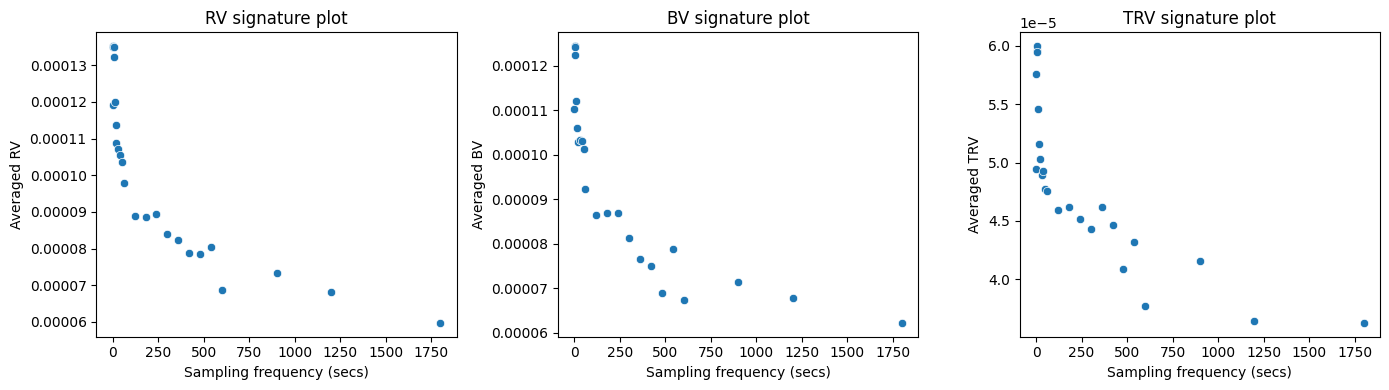

In [161]:
# Compute Average RVs across different days
RVav = RVdf.mean()
# Convert index to integers (sec)
RVav.index
time_RV = [0] + [pd.Timedelta(x).total_seconds() for x in RVav.index[1:]]


# Compute Average RVs across different days
BVav = BVdf.mean()
# Convert index to integers (sec)
BVav.index
time_BV = [0] + [pd.Timedelta(x).total_seconds() for x in BVav.index[1:]]


# Compute Average RVs across different days
TRVav = TRVdf.mean()
# Convert index to integers (sec)
TRVav.index
time_TRV = [0] + [pd.Timedelta(x).total_seconds() for x in TRVav.index[1:]]



fig, axes = plt.subplots(nrows=1,ncols=3,figsize=(14,4))

sns.scatterplot(x=time_RV,y=RVav,ax=axes[0])
axes[0].set_title('RV signature plot')
axes[0].set_xlabel('Sampling frequency (secs)')
axes[0].set_ylabel('Averaged RV')

sns.scatterplot(x=time_BV,y=BVav,ax=axes[1])
axes[1].set_title('BV signature plot')
axes[1].set_xlabel('Sampling frequency (secs)')
axes[1].set_ylabel('Averaged BV')

sns.scatterplot(x=time_TRV,y=TRVav,ax=axes[2])
axes[2].set_title('TRV signature plot')
axes[2].set_xlabel('Sampling frequency (secs)')
axes[2].set_ylabel('Averaged TRV')

plt.tight_layout()

# Task 2

In [162]:
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import random
import pandas as pd
import numpy as np

# Replace 'your_student_id' with your actual student ID number
student_id = 36629202  # Use your actual student ID here
random.seed(student_id)

# Assuming you have DowJones-Feb2022.csv available
djia_stocks = pd.read_csv('DowJones-Feb2022.csv')

# Exclude stock 'DOW' from the list and select two random stocks
djia_stocks = djia_stocks[djia_stocks['Ticker'] != 'DOW']
my_sample = random.sample(djia_stocks['Ticker'].tolist(), 2)

# Fetch the Adjusted Close prices for the selected stocks
stock_prices = {}
for stock in my_sample:
    stock_data = yf.download(stock, start='2010-01-01', end='2023-12-31')
    stock_prices[stock] = stock_data['Adj Close']

# Compute log daily returns for the selected stocks
daily_returns = {stock: np.log(prices).diff().dropna() for stock, prices in stock_prices.items()}

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [163]:
daily_returns

{'CSCO': Date
 2010-01-05   -0.004465
 2010-01-06   -0.006531
 2010-01-07    0.004495
 2010-01-08    0.005286
 2010-01-11   -0.002842
                 ...   
 2023-12-22    0.007816
 2023-12-26    0.003786
 2023-12-27    0.003177
 2023-12-28    0.000793
 2023-12-29    0.000792
 Name: Adj Close, Length: 3521, dtype: float64,
 'HD': Date
 2010-01-05    0.007298
 2010-01-06   -0.003469
 2010-01-07    0.011745
 2010-01-08   -0.004820
 2010-01-11   -0.028703
                 ...   
 2023-12-22   -0.001090
 2023-12-26    0.002063
 2023-12-27   -0.002235
 2023-12-28   -0.003363
 2023-12-29   -0.002335
 Name: Adj Close, Length: 3521, dtype: float64}

### Task 2.1

In [164]:
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
import random
import pandas as pd
import numpy as np

# Replace 'your_student_id' with your actual student ID number
student_id = 36629202  # Use your actual student ID here
random.seed(student_id)

# Assuming you have DowJones-Feb2022.csv available
djia_stocks = pd.read_csv('DowJones-Feb2022.csv')

# Exclude stock 'DOW' from the list and select two random stocks
djia_stocks = djia_stocks[djia_stocks['Ticker'] != 'DOW']
selected_stocks = random.sample(djia_stocks['Ticker'].tolist(), 2)

# Fetch the Adjusted Close prices for the selected stocks
stock_prices = {}
for stock in selected_stocks:
    stock_data = yf.download(stock, start='2010-01-01', end='2023-12-31')
    stock_prices[stock] = stock_data['Adj Close']

# Compute log daily returns for the selected stocks
log_returns = {stock: np.log(prices).diff().dropna() for stock, prices in stock_prices.items()}

# Fit ARMA models and find the best one based on AIC
best_models = {}
for stock, returns in log_returns.items():
    best_aic = float('inf')
    best_order = None
    best_model = None
    # Grid search for p,q values between 0 and 3
    for p in range(4):
        for q in range(4):
            try:
                model = ARIMA(returns, order=(p,0,q)).fit()
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p,q)
                    best_model = model
            except Exception as e:
                continue
    best_models[stock] = (best_model, best_order, best_aic)

# Print out the best-fitting models and their AIC
for stock, (model, order, aic) in best_models.items():
    if model is not None:
        print(f"Best-fitted ARMA model for {stock}: ARMA{order} - AIC = {aic:.4f}")
    else:
        print(f"No suitable ARMA model found for {stock}.")


[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed


Best-fitted ARMA model for CSCO: ARMA(1, 0) - AIC = -18842.5869
Best-fitted ARMA model for HD: ARMA(2, 0) - AIC = -19673.2550


In [165]:
# aicdf = pd.DataFrame(columns = ['p', 'q', 'r', 'AIC', 'fit'])
# for stock in my_sample:
#     ARMA_parameter(daily_returns[stock])

In [166]:
# my_sample

In [167]:
# aicdf

In [168]:
# for stock in my_sample:
#     print(f"Best-fitted ARMA model for {stock}: ARMA({aicdf['p'][stock]},{aicdf['q'][stock]}) - AIC = {aicdf['AIC'][stock]}")

### Task 2.2

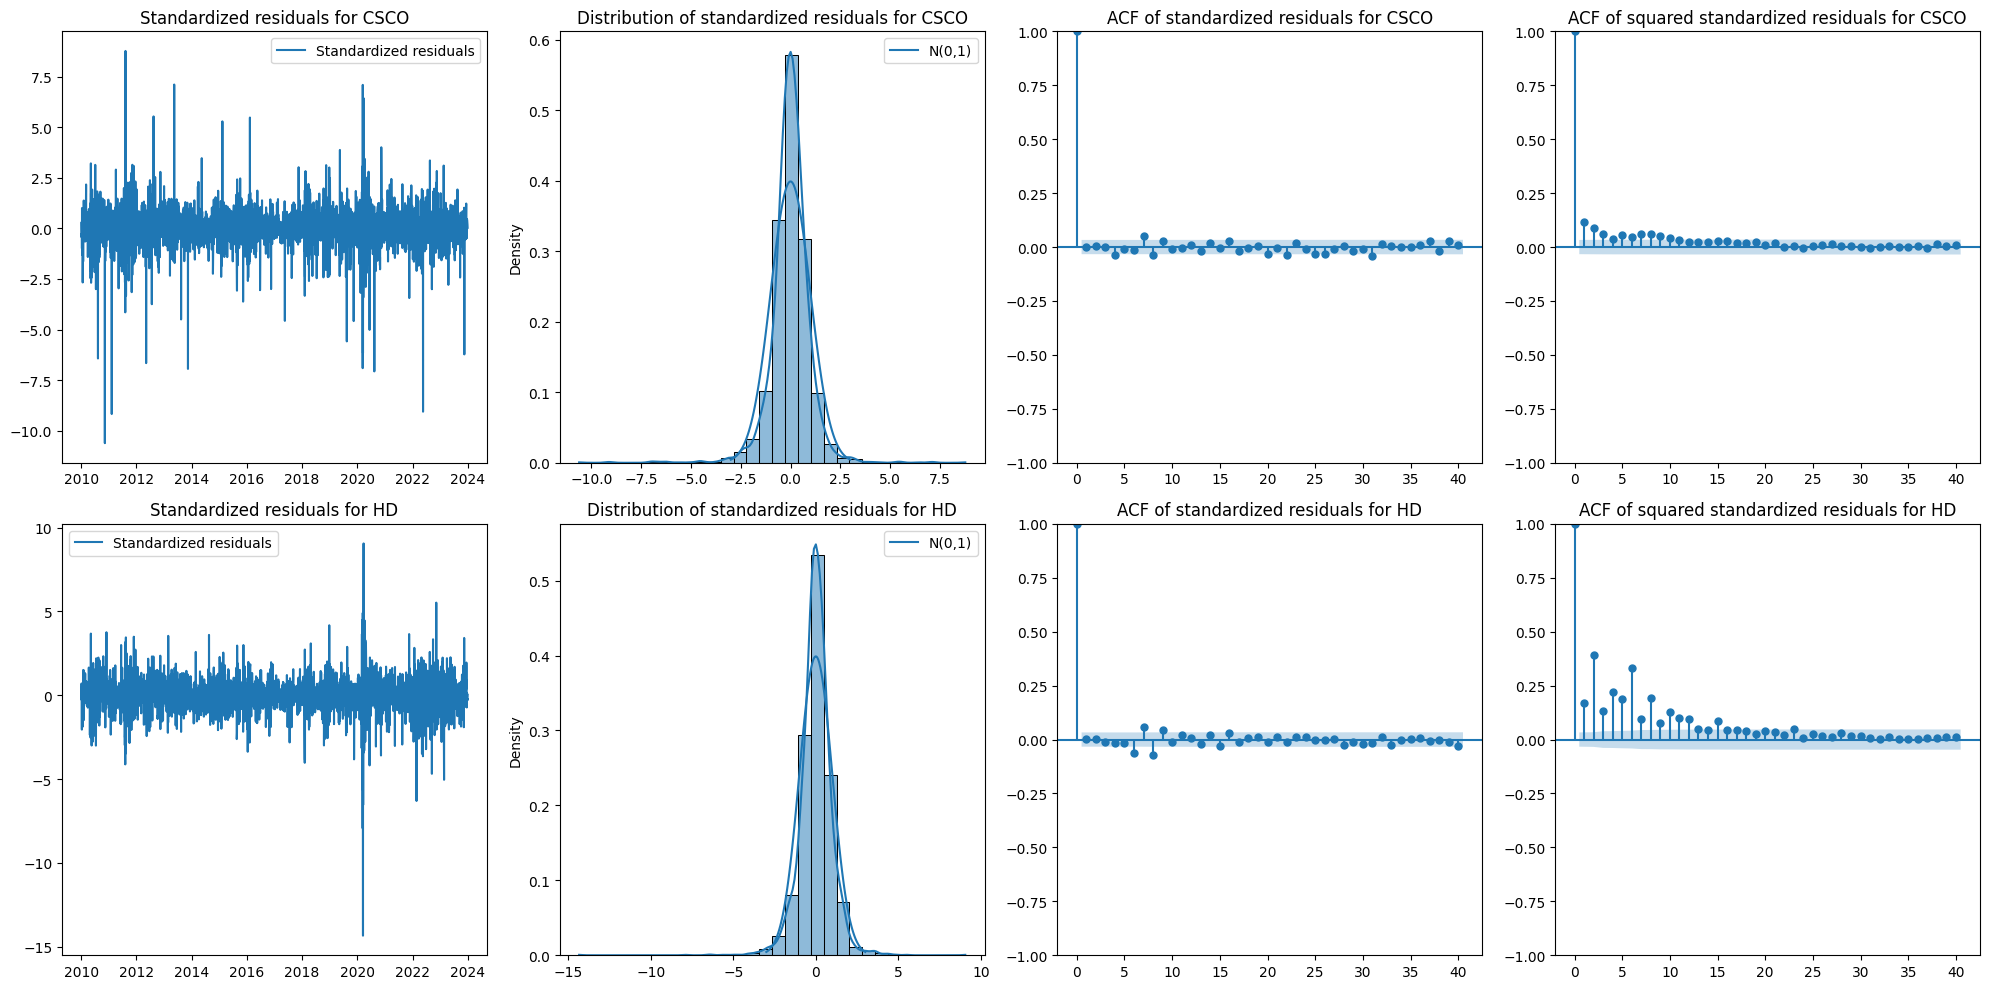

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import numpy as np

# Assuming 'best_models' contains the best ARMA models from Task 2.1
# And 'log_returns' contains the log returns for each stock
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, (stock, (model, order, aic)) in enumerate(best_models.items()):
    # Standardized residuals
    std_resid = model.resid / model.resid.std()

    # Time series plot of the standardized residuals
    axes[i, 0].plot(std_resid, label='Standardized residuals')
    axes[i, 0].set_title(f'Standardized residuals for {stock}')
    axes[i, 0].legend()

    # Histogram with KDE and standard normal distribution
    sns.histplot(std_resid, kde=True, ax=axes[i, 1], stat='density', bins=30)
    x = np.linspace(-3, 3, 100)
    axes[i, 1].plot(x, stats.norm.pdf(x), label='N(0,1)')
    axes[i, 1].set_title(f'Distribution of standardized residuals for {stock}')
    axes[i, 1].legend()

    # ACF of the standardized residuals
    plot_acf(std_resid, ax=axes[i, 2], lags=40, alpha=0.05)
    axes[i, 2].set_title(f'ACF of standardized residuals for {stock}')

    # ACF of the squared standardized residuals
    plot_acf(std_resid**2, ax=axes[i, 3], lags=40, alpha=0.05)
    axes[i, 3].set_title(f'ACF of squared standardized residuals for {stock}')

plt.tight_layout()
plt.show()


### Task 2.3

In [170]:
# Fit ARMA models and find the best one based on AIC
garch_best_models = {}
for stock, returns in log_returns.items():
    best_aic = float('inf')
    best_order = None
    best_model = None
    # Grid search for p,q values between 0 and 3
    for p in range(4):
        for q in range(4):
            try:
                model = arch_model(returns, mean='AR', lags=[best_models[stock][1][0]], vol='Garch', p=p, q=q, dist='t').fit(update_freq=5, disp='off')
                if model.aic < best_aic:
                    best_aic = model.aic
                    best_order = (p,q)
                    best_model = model
            except Exception as e:
                continue
    garch_best_models[stock] = (best_model, best_order, best_aic)

c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
c:\Users\prvij\AppData\Local\Programs\Python\Python312\Lib\site-packages\arch\univariate\base.py:766: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive direction

In [171]:
# Print out the best-fitting models and their AIC
for stock, (model, order, aic) in garch_best_models.items():
    if model is not None:
        print(f"Best-fitted AR(p)-GARCH(p*,q*) model for {stock}: AR({garch_best_models[stock][1][0]})-GARCH({garch_best_models[stock][1][0]},{garch_best_models[stock][1][1]}) - AIC = {garch_best_models[stock][2]}")
    else:
        print(f"No suitable ARMA model found for {stock}.")


Best-fitted AR(p)-GARCH(p*,q*) model for CSCO: AR(3)-GARCH(3,2) - AIC = -13729.965341725541
Best-fitted AR(p)-GARCH(p*,q*) model for HD: AR(2)-GARCH(2,3) - AIC = -13202.722966264711


In [172]:
# best_models[stock][1][1]

In [173]:
# best_models[stock][2]

In [174]:
# best_models[stock][1]

In [175]:
# for stock, returns in log_returns.items():
#     print(stock)

In [176]:
# # Choose ARMA parameters to minimize AIC

# def ARMA_parameter(stock, returns):
#     aicVal=[]
#     for p in range(0,4):
#         for q in range(0,4):
#             try:
#                 gm = arch_model(returns,mean='AR',lags=,vol='GARCH',p=p,q=q,dist='t')
#                 gm_fit = gm.fit()
#                 r = gm_fit.std_resid.dropna()
#                 aicVal.append([p, q, r, gm_fit.aic, gm_fit])
#             except:
#                 continue
#     aicVal = pd.DataFrame(aicVal, columns = ['p', 'q', 'r', 'AIC', 'fit'])
#     # print(aicVal)
#     p,q,r,AIC,fit = aicVal.iloc[aicVal['AIC'].argmin(),]
#     gaicdf.loc[returns.name] = {'p': p, 'q': q, 'r': r, 'AIC': AIC, 'fit':fit}

In [177]:
# gaicdf = pd.DataFrame(columns = ['p', 'q', 'r', 'AIC', 'fit'])
# for stock in my_sample:
#     ARMA_parameter(daily_returns[stock])

In [178]:
# for stock in my_sample:
#     print(f'Best-fitted AR(p)-GARCH(p*,q*) model for {stock}: AR({aicdf['p'][stock]})-GARCH({gaicdf['p'][stock]},{gaicdf['q'][stock]}) - AIC = {gaicdf['AIC'][stock]}')

### Task 2.4

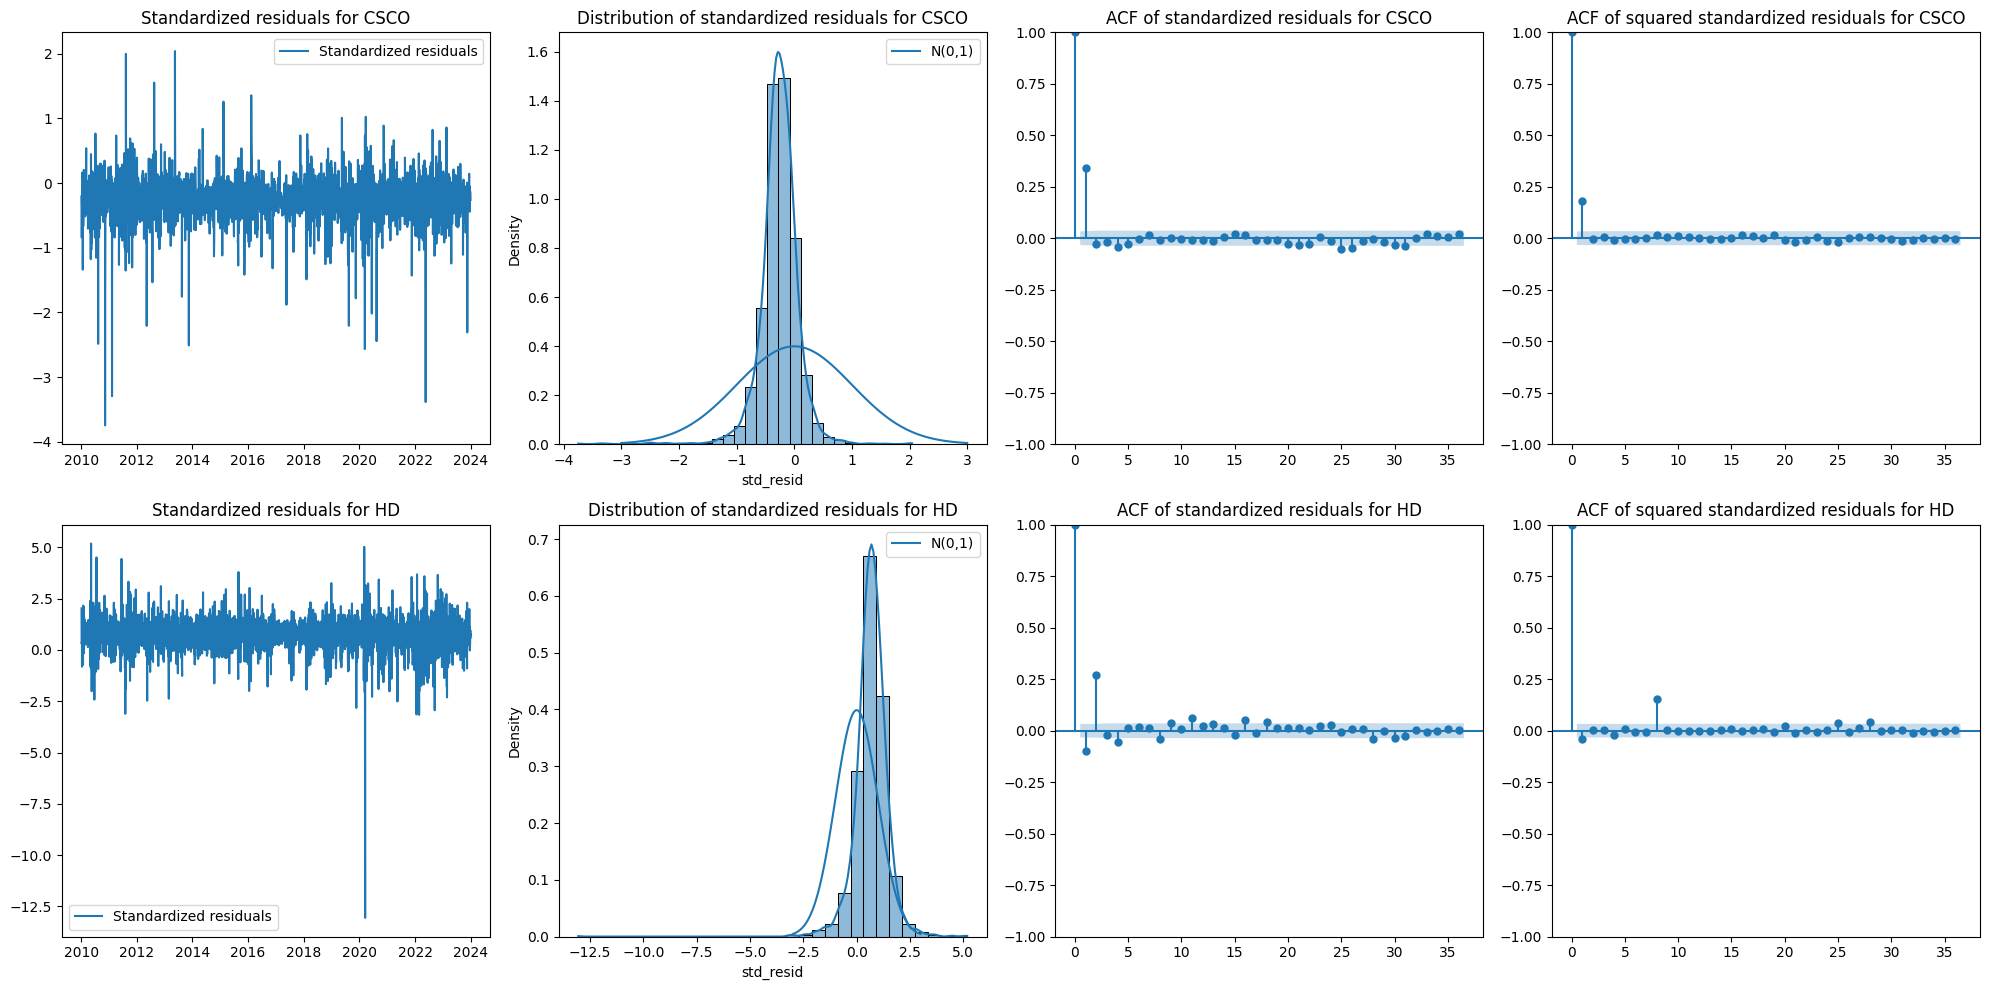

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import numpy as np

# Assuming 'best_models' contains the best ARMA models from Task 2.1
# And 'log_returns' contains the log returns for each stock
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, (stock, (model, order, aic)) in enumerate(garch_best_models.items()):
    # Standardized residuals
    std_resid = model.std_resid.dropna()

    # Time series plot of the standardized residuals
    axes[i, 0].plot(std_resid, label='Standardized residuals')
    axes[i, 0].set_title(f'Standardized residuals for {stock}')
    axes[i, 0].legend()

    # Histogram with KDE and standard normal distribution
    sns.histplot(std_resid, kde=True, ax=axes[i, 1], stat='density', bins=30)
    x = np.linspace(-3, 3, 100)
    axes[i, 1].plot(x, stats.norm.pdf(x), label='N(0,1)')
    axes[i, 1].set_title(f'Distribution of standardized residuals for {stock}')
    axes[i, 1].legend()

    # ACF of the standardized residuals
    plot_acf(std_resid, ax=axes[i, 2], alpha=0.05)
    axes[i, 2].set_title(f'ACF of standardized residuals for {stock}')

    # ACF of the squared standardized residuals
    plot_acf(std_resid**2, ax=axes[i, 3],  alpha=0.05)
    axes[i, 3].set_title(f'ACF of squared standardized residuals for {stock}')

plt.tight_layout()
plt.show()


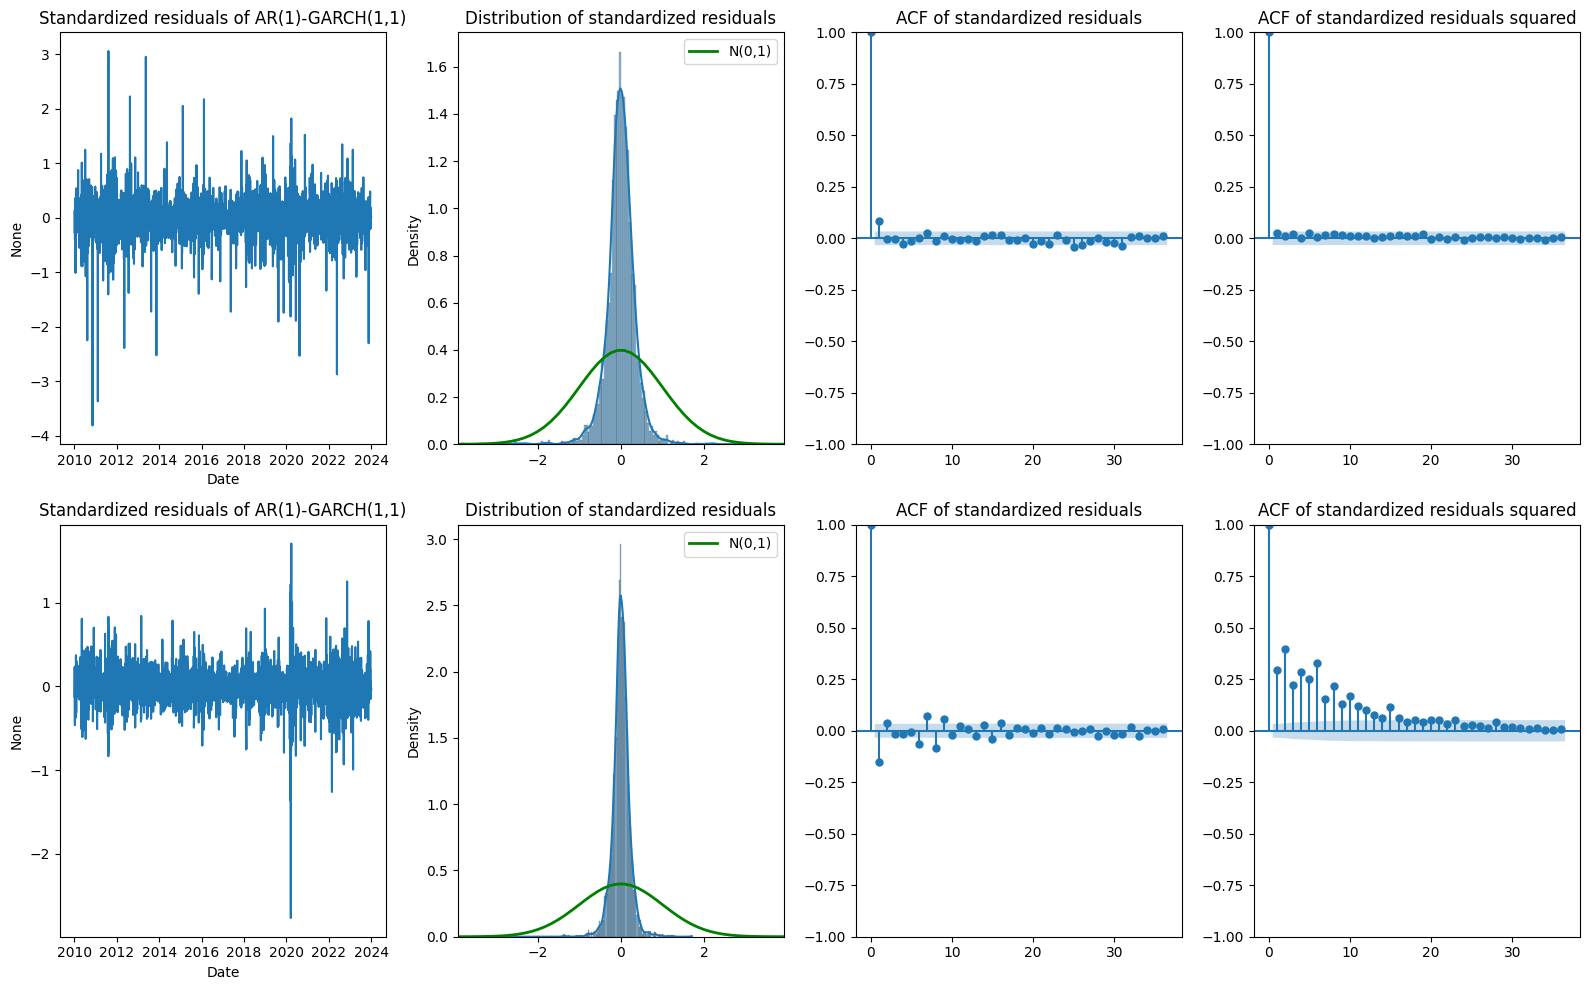

In [180]:
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as scs
fig, axes = plt.subplots(nrows=2,ncols=4,figsize=(16,10))
for i,stock in enumerate(my_sample):
    p = gaicdf.loc[stock]['p']
    q = gaicdf.loc[stock]['q']
    r = gaicdf.loc[stock]['r'] # Extract standardized residuals
    r.name = None

    # Time series plot of Standardized residuals
    sns.lineplot(x=r.index, y=r, ax=axes[i,0])
    axes[i,0].set_title('Standardized residuals of AR(1)-GARCH(1,1)')
    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    sns.histplot(r,kde=True,stat='density',ax=axes[i,1])
    axes[i,1].plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    axes[i,1].set_title('Distribution of standardized residuals')
    axes[i,1].set_xlim(x_lim)
    axes[i,1].legend()
    # ACF plot of standardized residual
    plot_acf(r, ax=axes[i,2], alpha=0.05)
    axes[i,2].set_title('ACF of standardized residuals')
    # ACF plot of squared standardized residual
    plot_acf(r**2, ax=axes[i,3], alpha=0.05)
    axes[i,3].set_title('ACF of standardized residuals squared')

plt.tight_layout()

### Task 2.5

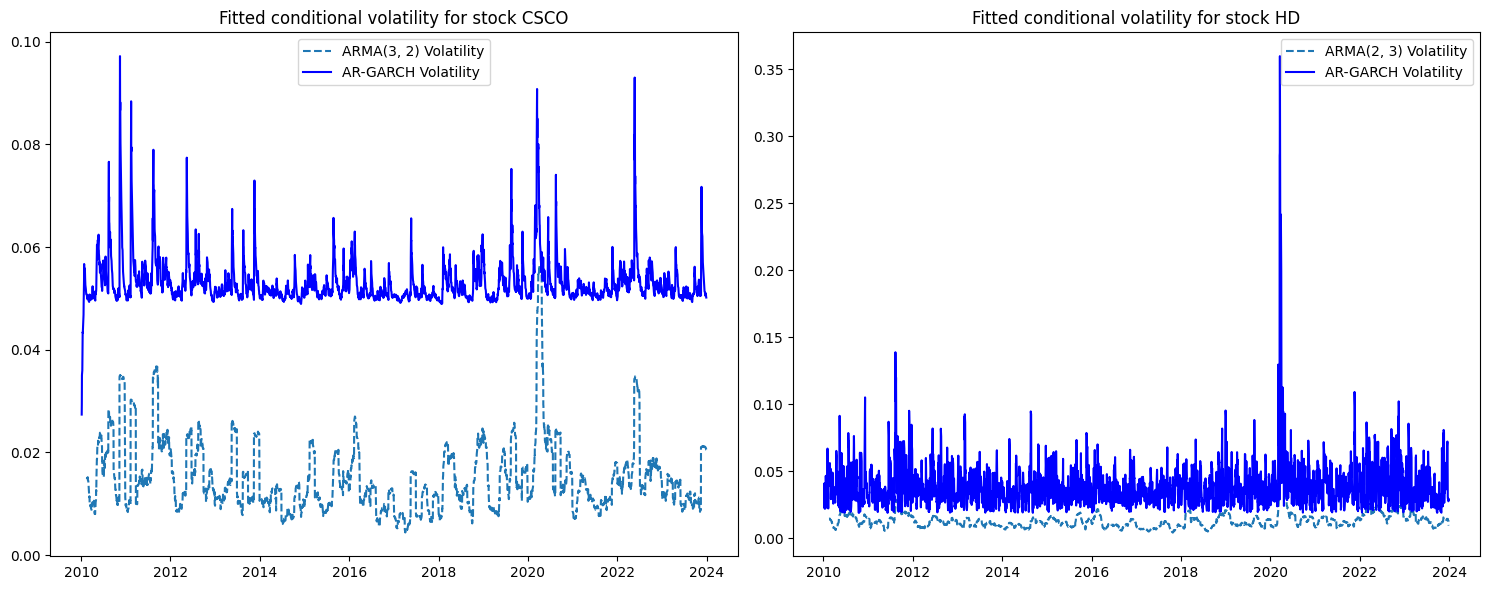

In [181]:
import matplotlib.pyplot as plt

# Ensure that you have 'best_models' from Task 2.1 and 'garch_models' from Task 2.3 ready.
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

for i, stock in enumerate(selected_stocks):
    # ARMA Model implied volatility (rolling standard deviation of the residuals)
    arma_model, order, aic = best_models[stock]
    arma_volatility = arma_model.resid.rolling(window=30).std()  # 30-day rolling window

    # AR-GARCH Model implied volatility
    garch_model, order, aic = garch_best_models[stock]
    garch_volatility = garch_model.conditional_volatility

    # Plotting the ARMA and AR-GARCH volatility
    axes[i].plot(arma_volatility, label=f'ARMA{order} Volatility', linestyle='--')
    axes[i].plot(garch_volatility, label=f'AR-GARCH Volatility', linestyle='-', c = 'b')

    axes[i].set_title(f'Fitted conditional volatility for stock {stock}')
    axes[i].legend()

plt.tight_layout()
plt.show()


In [182]:
best_models[stock][0]

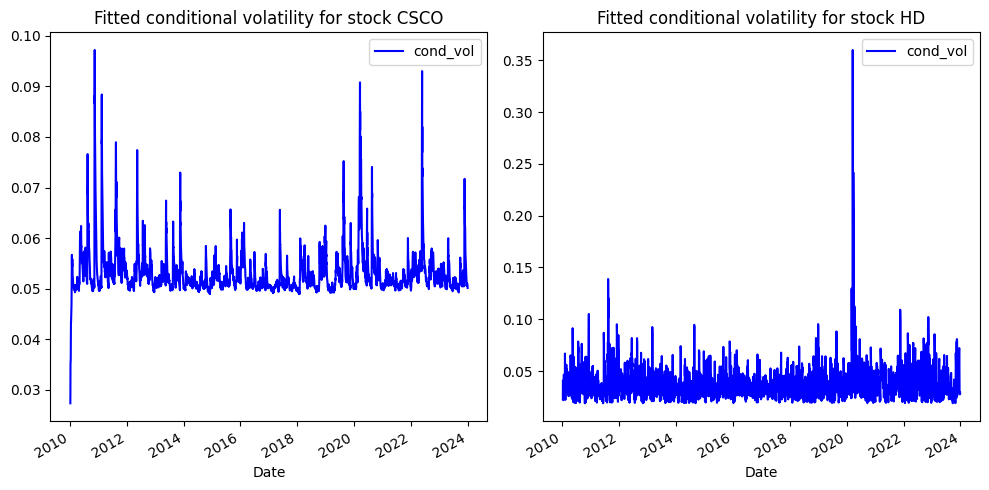

In [183]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize = (10, 5))
for i,stock in enumerate(my_sample):
    garch_best_models[stock][0].conditional_volatility.plot(ax = axes[i], c = 'b')
    axes[i].set_title(f'Fitted conditional volatility for stock {stock}')
    axes[i].legend()
plt.tight_layout()
plt.show()

# Task 3

### Task 3.1

In [216]:
best_models['CSCO'][0]

In [215]:
best_models['CSCO'][0].get_forecast().summary_frame()

Adj Close,mean,mean_se,mean_ci_lower,mean_ci_upper
3521,0.000278,0.016647,-0.03235,0.032905


In [ ]:
data_train = data[data.index <= '2021-12-31']


In [ ]:
# Compute one-step ahead forecasts for S&P500 price using ARIMA(1,1,0) and ARIMA(1,1,1)
arima110_p_fcast = [] # Initialize forecast list for ARIMA(1,1,0) model
arima312_p_fcast = [] # Initialize forecast list for ARIMA(3,1,2) model
dates_oss = data.index[data.index >= '2022-01-01']

for fdate in dates_oss:
    # Step 1: Get an expanded in-sample data by one obs at a time
    y = data.loc[data.index < fdate,'price']
    
    # Step 2: Apply the estimated model to the new data
    arima110_p_ext = arima110_p.apply(y, refit=False)
    arima312_p_ext = arima312_p.apply(y, refit=False)
    
    # Step 3: Produce and save one-step ahead forecast
    arima110_p_fcast.append(arima110_p_ext.forecast().iloc[0])
    arima312_p_fcast.append(arima312_p_ext.forecast().iloc[0])
    
arima110_p_fcast = pd.Series(arima110_p_fcast, index = dates_oss)
arima312_p_fcast = pd.Series(arima312_p_fcast, index = dates_oss)
print(arima110_p_fcast)
print(arima312_p_fcast)

In [218]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

forecast_dfs = {}
forecast_models = {}

for stock in selected_stocks:
    model = best_models[stock][0]
    endog = stock_prices[stock]
    in_sample_endog = endog.loc[endog.index < '2021-01-01']
    out_of_sample_endog = endog.loc[endog.index >= '2021-01-01']

    # Extract the AR order from Task 2.1 (assuming this is the 'p' in an AR(p) model)
    # We insert 0 for the I(d) part since ARMA models do not include differencing
    p_order = best_models[stock][1][0]
    arma_order = (p_order, 0, best_models[stock][1][1])

    # Refit the model with in-sample data
    refit_model = SARIMAX(in_sample_endog, order=arma_order).fit(disp=False)

    # Initialize the forecast dataframe
    forecast_df = pd.DataFrame(columns=['f', 'fl', 'fu'], index=out_of_sample_endog.index)

    for date in forecast_df.index:
        forecast = refit_model.get_forecast(steps=1)
        forecast_df.loc[date] = [forecast.predicted_mean.iloc[0], *forecast.conf_int(alpha=0.05).iloc[0]]

        # Update the model by appending the new observation
        refit_model = refit_model.append(endog=[out_of_sample_endog[date]], refit=False)

    forecast_dfs[stock] = forecast
    forecast_models[stock] = refit_model

# Display the forecast results
for stock, forecast_df in forecast_dfs.items():
    print(f"Forecasts for {stock}:")
    print(forecast_df.head())


Forecasts for CSCO:


AttributeError: 'PredictionResults' object has no attribute 'head'

In [209]:
ar1_apgarch11_fcast = forecast_models['CSCO'].forecast(reindex=False)
ar1_apgarch11_fcast.mean['h.1'].plot(ax=axes[0],title='One-step return forecasts')


TypeError: 'method' object is not subscriptable

In [186]:
stock_prices[stock]

Date
2010-01-04     20.428896
2010-01-05     20.578531
2010-01-06     20.507277
2010-01-07     20.749546
2010-01-08     20.649784
                 ...    
2023-12-22    346.517517
2023-12-26    347.233246
2023-12-27    346.457886
2023-12-28    345.294830
2023-12-29    344.489624
Name: Adj Close, Length: 3522, dtype: float64

In [208]:
forecast.mean['h.1'].plot(title='One-step return forecasts')

AttributeError: 'PredictionResults' object has no attribute 'mean'

In [ ]:
r_true.plot(ax=ax[1],style='b',label='Observed returns')
mean_fcast.plot(ax=ax[1],style='k',label='Mean forecasts')
mean_fcast_lb.plot(ax=ax[1],style='g--',label='95% IC')
mean_fcast_ub.plot(ax=ax[1],style='g--',label='')
ax[1].set_title('One-step conditional mean forecasts')
ax[1].set_xlim(mean_fcast.index[0],mean_fcast.index[-1])
ax[1].legend(loc='best')



In [187]:
data = stock_prices['CSCO']

In [190]:
forecast_dfs[stock]

,f,fl,fu
Date,,,
2021-01-04,245.401198,241.558079,249.244318
2021-01-05,244.080859,240.237739,247.923978
2021-01-06,245.583278,241.740159,249.426398
2021-01-07,247.06201,243.218891,250.905129
2021-01-08,246.195685,242.352565,250.038804
...,...,...,...
2023-12-22,346.83349,342.990371,350.67661
2023-12-26,346.546028,342.702909,350.389148
2023-12-27,347.117819,343.2747,350.960939


<Axes: xlabel='Date'>

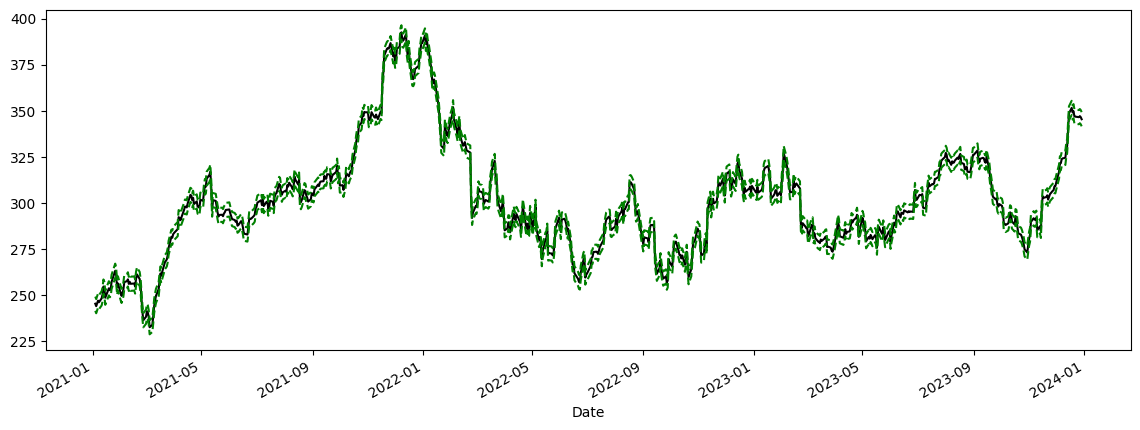

In [202]:
fig, ax = plt.subplots(1, 1, figsize = (14,5))
r_true = garch_best_models[stock][0].conditional_volatility*100
mean_fcast = forecast_dfs[stock]['f']
mean_fcast_lb = forecast_dfs[stock]['fl'] # Lower bound 95%
mean_fcast_ub = forecast_dfs[stock]['fu'] # Upper bound 95%

# ax[1]: Mean forecast vs true
# r_true.plot(style='b',label='Observed returns')
mean_fcast.plot(style='k',label='Mean forecasts')
mean_fcast_lb.plot(style='g--',label='95% IC')
mean_fcast_ub.plot(style='g--',label='')
# ax[0].set_title('One-step conditional mean forecasts')
# ax[0].set_xlim(mean_fcast.index[0],mean_fcast.index[-1])
# ax[0].legend(loc='best')

